# <a id='toc1_'></a>[AC209b · Milestone 4](#toc0_)
**Project 41, Group 66**  
Alia Lu · Hebe Chen · Luc Chen · Yushu Qiu · Zhilin Chen  

**Dataset:** Jigsaw Multilingual Toxic Comment Classification  
**GitHub Repository**: [Multilingual Toxic Comment Classification](https://github.com/Lucchh/Multilingual-Toxic-Comment-Classification)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast 
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.optim import AdamW 
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset
from sklearn.metrics import log_loss
import nlpaug.augmenter.word as naw

**Table of contents**<a id='toc0_'></a>    
- [AC209b · Milestone 4](#toc1_)    
  - [Problem Statement](#toc1_1_)    
  - [Comprehensive EDA Review](#toc1_2_)    
    - [Label Distribution](#toc1_2_1_)    
    - [Length Distribution](#toc1_2_2_)    
    - [Label Correlation Heatmap](#toc1_2_3_)    
    - [Feature Engineering Summary](#toc1_2_4_)    
    - [Top TF-IDF Features](#toc1_2_5_)    
    - [Top Words in Toxic vs. Non-Toxic Comments](#toc1_2_6_)    
  - [3 Model Choice & Justification](#toc1_3_)    
    - [Training Process](#toc1_3_1_)    
  - [Final Model Pipeline Setup](#toc1_4_)    
      - [Data Preparation](#toc1_4_1_1_)    
      - [Model and Training Configuration](#toc1_4_1_2_)    
      - [Training and Validation Loop](#toc1_4_1_3_)    
      - [Save Model and Tokenizer](#toc1_4_1_4_)    
      - [Evaluate Model by Label](#toc1_4_1_5_)    
      - [Plot Training Metrics](#toc1_4_1_6_)    
  - [Results Interpretation and Analysis](#toc1_5_)    
    - [**5. Comparative Analysis: Baseline vs. Final Model**](#toc1_5_1_)    
  - [Conclusion, Limitations, and Future Work](#toc1_6_)    
  - [Appendix: (Data Augmentation)- Over Sample](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Problem Statement](#toc0_)

Toxic comments on the internet pose serious challenges to online communities, making it important to detect and filter harmful language automatically. Our project focuses on building a system that can detect different types of toxicity, such as insults, threats, and hate speech, in user-generated comments. What makes this task particularly hard is that a single comment might contain multiple types of toxicity at once, and that some forms (like threats) are much rarer than others. Our goal is to create a model that can accurately identify these labels, even when they co-occur or appear in subtle way, which is very challenging.

We use the Jigsaw Multilingual Toxic Comment Classification dataset, which includes comments in multiple languages and assigns six binary toxicity labels to each. This makes our task a multilabel classification problem, each comment needs to be evaluated independently for each type of toxicity.

Our initial assumption was that toxic comments might be longer or more detailed, especially when someone gets angry or upset, and we expected threats or hateful speech to involve more words and emotional buildup than short, polite comments. However, EDA revealed that toxic comments are often shorter than non-toxic ones, contradicting our expectations. We also assumed toxicity labels would be mostly independent, but we discovered that "obscene" and "insult" often co-occur, suggesting overlap in semantics. This prompted us to think more critically about label relationships and consider models that treat them jointly rather than independently. These insights led us to prioritize handling class imbalance, manage short-text sparsity, and plan for modeling label correlations in future iterations.



## <a id='toc1_2_'></a>[Comprehensive EDA Review](#toc0_)

In [17]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')
test_labels.replace(-1, 0, inplace=True)
print(train_df.shape)
print(train_df.columns)
print(train_df.dtypes)
train_df.head()
# missingness
train_df.isnull().sum().sort_values(ascending=False)

(159571, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### <a id='toc1_2_1_'></a>[Label Distribution](#toc0_)

We could see there is an extreme class imbalance present in the training data, as we can see from below Figure 1(a) and Figure 1(b). From Figure 1(a), the “toxic” label is by far the most common, with over 15,000 comments, followed by “obscene” and “insult.” In contrast, categories like “severe_toxic,” “identity_hate,” and especially “threat” have drastically fewer positive examples, less than a tenth of the most common labels.

We further illustrate the data imbalance issue by visualizing the percentage of comments labeled as "1" for each type of toxicity in the dataset, as shown in Figure 1(b). Approximately 10% of comments are labeled as toxic, around 1% as severe toxic, about 5% contain obscene language, roughly 0.5% include threats, approximately 5% are labeled as insults, and around 1% involve identity hate.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast 
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.optim import AdamW 
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset
from sklearn.metrics import log_loss
import nlpaug.augmenter.word as naw

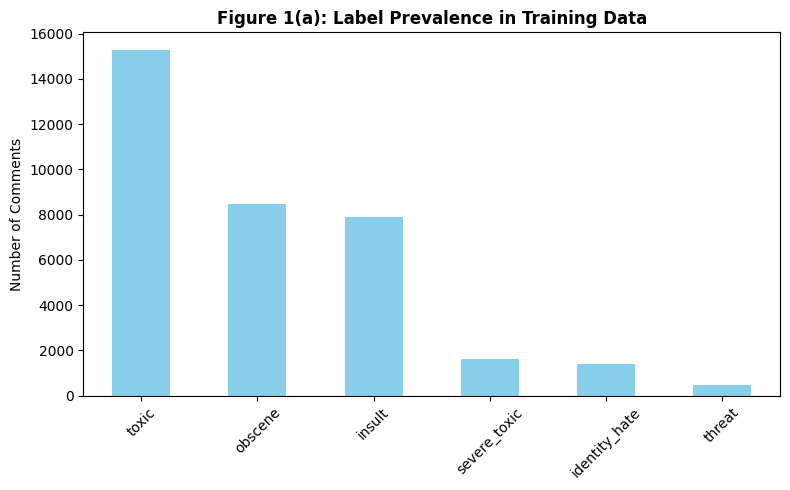

In [27]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = train_df[label_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Figure 1(a): Label Prevalence in Training Data', fontweight='bold')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


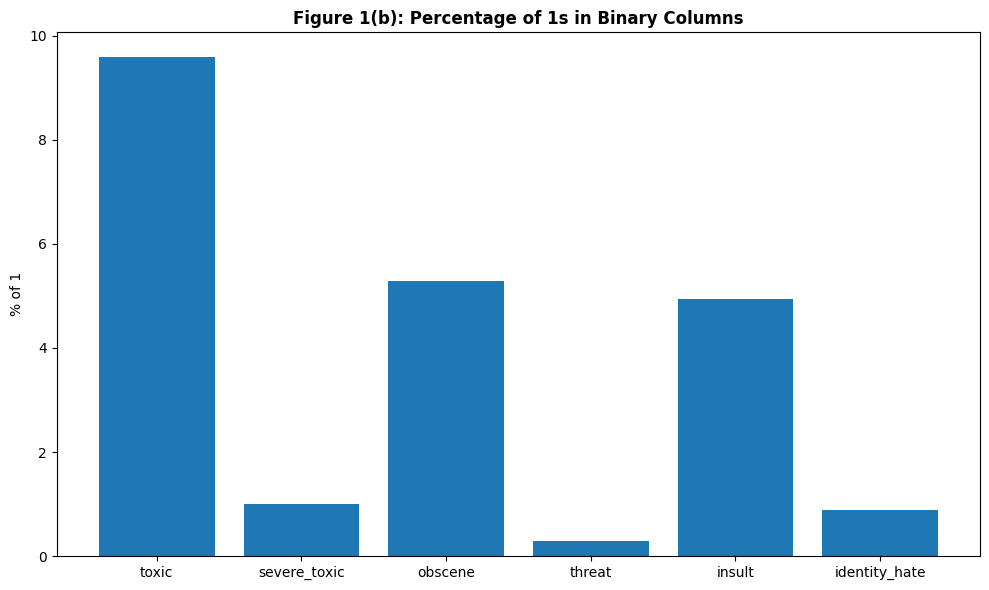

In [29]:
binary_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
zero_percentages = {}
for col in binary_cols:
    zero_percentages[col] = (100 * (train_df[col] == 1).sum()) / len(train_df[col])

plt.figure(figsize=(10, 6))
plt.bar(zero_percentages.keys(), zero_percentages.values())
plt.ylabel('% of 1')
plt.title('Figure 1(b): Percentage of 1s in Binary Columns',fontweight = 'bold')
plt.tight_layout()
plt.show()

### <a id='toc1_2_2_'></a>[Length Distribution](#toc0_)

The histogram in Figure 2 shows a highly right-skewed distribution of comment lengths, with the vast majority of comments containing fewer than 50 words. It's worth highlighting that the highest frequency is concentrated around the 10–20 word range, and the count drops off sharply as the length increases. While a small number of long comments exist (up to 500 words), they are extremely rare.

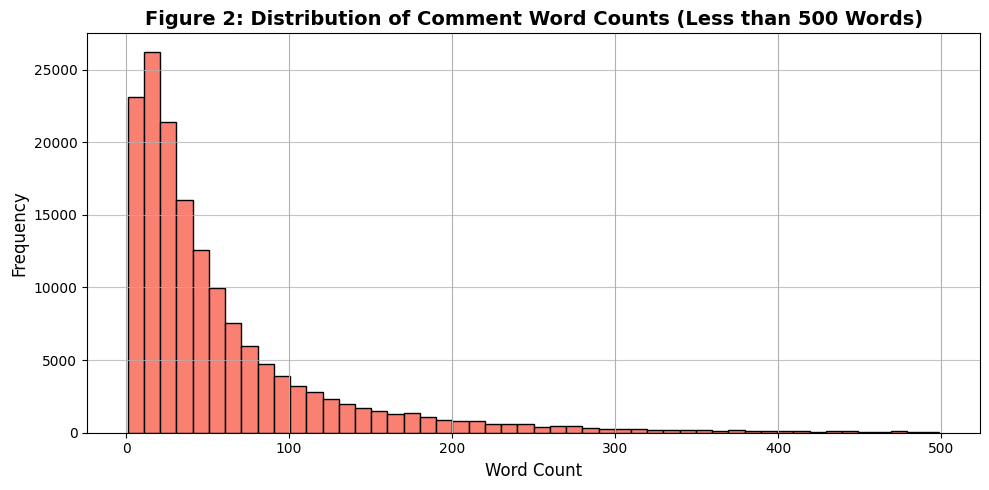

In [5]:
#word count
train_df['word_count'] = train_df['comment_text'].apply(lambda x: len(str(x).split()))

# word count <500
plt.figure(figsize=(10, 5))
train_df[train_df['word_count'] < 500]['word_count'].hist(bins=50, color='salmon', edgecolor='black')
plt.title('Figure 2: Distribution of Comment Word Counts (Less than 500 Words)', fontsize=14, fontweight='bold')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### <a id='toc1_2_3_'></a>[Label Correlation Heatmap](#toc0_)

This heatmap from Figure 3 shows how different toxic behaviors are related. For example, "obscene" and "insult" are often found together, with a strong link of 0.74. "Toxic" is also linked to "insult" (0.65) and "obscene" (0.68), meaning these often go hand in hand with general toxicity. On the other hand, "threat" doesn't really connect much with the others (all ≤ 0.16), so it might need special attention. This means if we treat each label as totally separate, we might miss some important connections. By considering how these labels relate, like using multi-task learning or other smart methods, we could make our model better at spotting different kinds of toxic behavior that happen together.

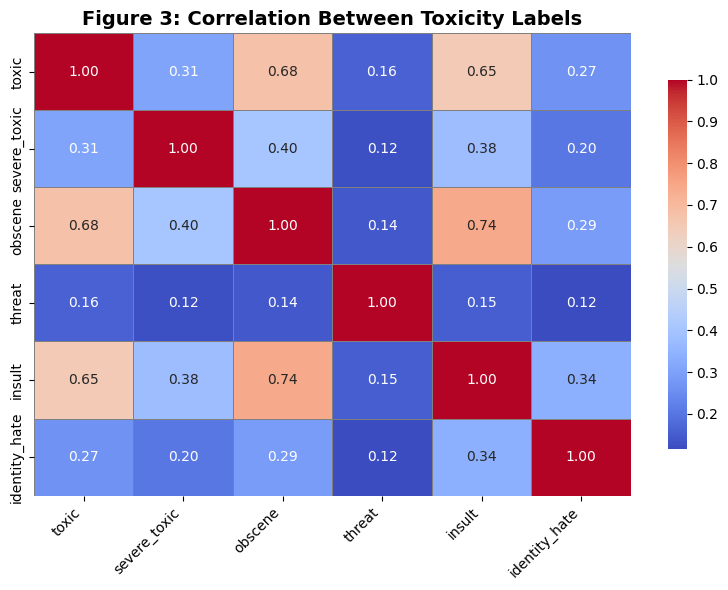

In [6]:
corr = train_df[label_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8})
plt.title('Figure 3: Correlation Between Toxicity Labels', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### <a id='toc1_2_4_'></a>[Feature Engineering Summary](#toc0_)

Before extracting features with TF-IDF, we applied basic text cleaning to remove HTML tags, punctuation, digits, and extra spaces. This reduces noise in the input and allows the model to focus on meaningful language patterns. The cleaned text is used for vectorization, while earlier EDA was performed on the raw text to preserve original structure (word count, character length).

In [7]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # rm html tags
    text = re.sub(r'http\S+|www\S+', '', text)  # remove urls
    text = re.sub(r'\d+', '', text)  # rm digits
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # rm punctution
    text = re.sub(r'\s+', ' ', text).strip()  # rm extra whitespace ( )
    return text

### <a id='toc1_2_5_'></a>[Top TF-IDF Features](#toc0_)

Figure 4 shows the bar chart of the top 20 words that pop up the most in our training data using TF-IDF. A lot of these words are not toxic and are related to Wikipedia, like "article," "page," "talk," "wikipedia," and nice words like "thank," "thanks," and "good."

This shows that TF-IDF often picks up on words that are used a lot, which might not help much in finding toxic stuff. For example, nice or discussion-related words might show up a lot, even if they don't really tell us about toxic behavior.

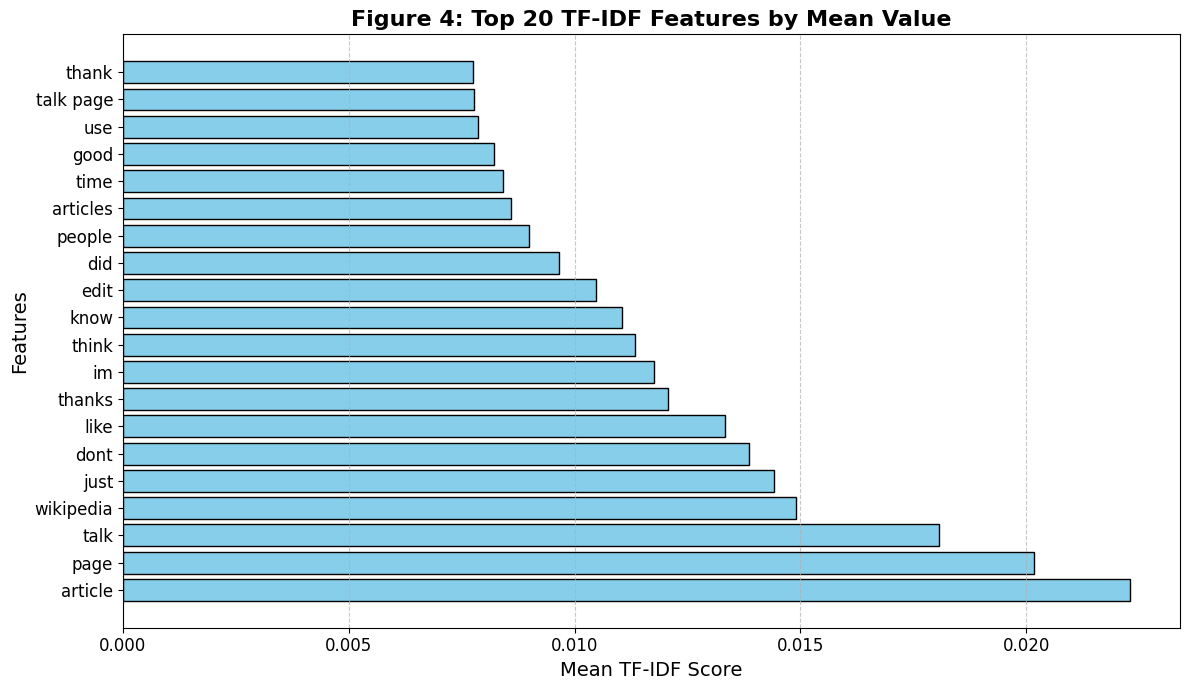

In [9]:
train_df['cleaned_text'] = train_df['comment_text'].apply(clean_text)
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(train_df['cleaned_text'])
tfidf_means = np.asarray(X.mean(axis=0)).flatten()
top_indices = np.argsort(tfidf_means)[::-1][:20]
top_words = np.array(vectorizer.get_feature_names_out())[top_indices]

plt.figure(figsize=(12, 7))
plt.barh(top_words[::-1], tfidf_means[top_indices][::-1], color='skyblue', edgecolor='black')
plt.title("Figure 4: Top 20 TF-IDF Features by Mean Value", fontsize=16, fontweight='bold')
plt.xlabel("Mean TF-IDF Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

### <a id='toc1_2_6_'></a>[Top Words in Toxic vs. Non-Toxic Comments](#toc0_)

Figure 5 illustrates the bar charts comparing the top 15 most frequent words in toxic and non-toxic comments. As expected, many high-frequency words are shared (e.g., "you", "the", "and"), but toxic comments also contain more aggressive or explicit language such as "f*ck", "your", and "are" used in a hostile tone. Non-toxic comments, on the other hand, show more balanced and neutral vocabulary. This difference reinforces our decision to use TF-IDF as it captures word importance across documents, and supports the assumption that lexical patterns can help distinguish toxic content.

Figure 5 also makes us take a step back to think about its limitations. Eventually it is bag-of-words based, ignoring context, word order, tone, or negation. For example, “you’re right” and “you’re trash” are treated similarly in terms of structure. It struggles with short texts, which dominate the dataset. Many comments are too brief to generate meaningful TF-IDF variation.


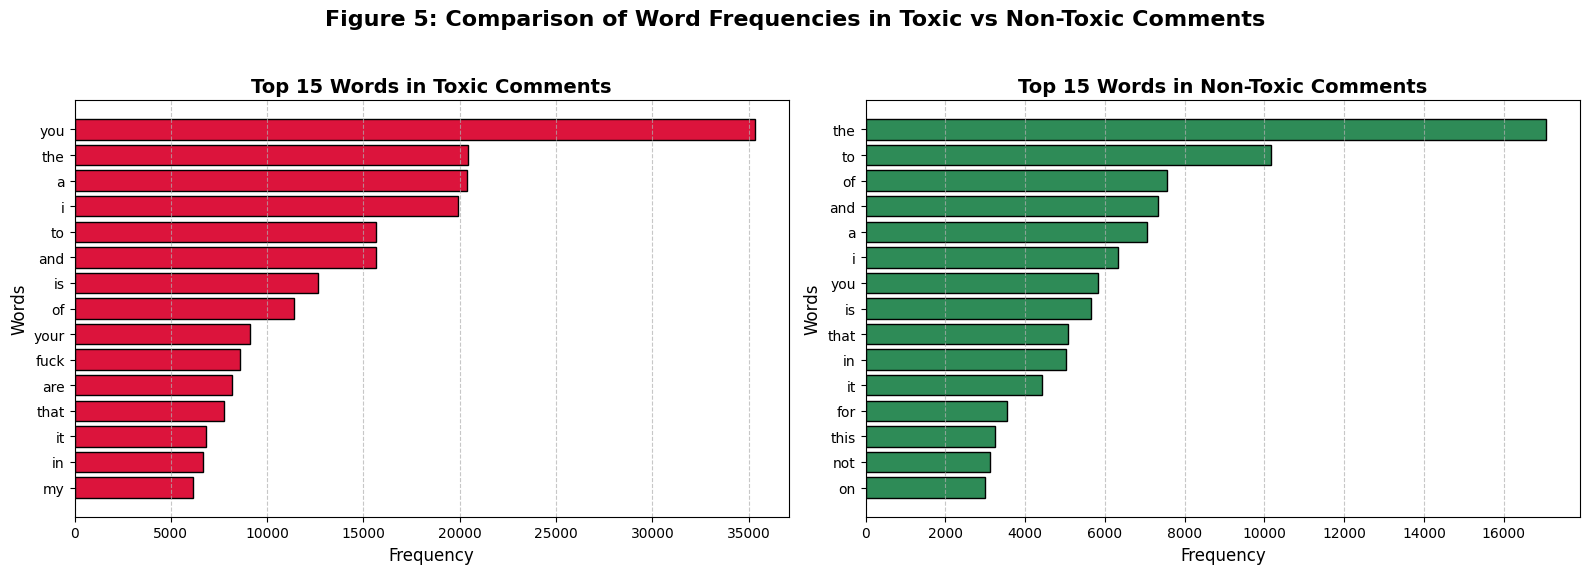

In [10]:
toxic_words = ' '.join(train_df[train_df['toxic'] == 1]['cleaned_text']).split()
non_toxic_words = ' '.join(train_df[train_df['toxic'] == 0]['cleaned_text'].sample(5000)).split()

toxic_freq = Counter(toxic_words).most_common(15)
non_toxic_freq = Counter(non_toxic_words).most_common(15)
toxic_words, toxic_counts = zip(*toxic_freq)
non_toxic_words, non_toxic_counts = zip(*non_toxic_freq)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# toxic
axes[0].barh(toxic_words[::-1], toxic_counts[::-1], color='crimson', edgecolor='black')
axes[0].set_title('Top 15 Words in Toxic Comments', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Words', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# not toxic words
axes[1].barh(non_toxic_words[::-1], non_toxic_counts[::-1], color='seagreen', edgecolor='black')
axes[1].set_title('Top 15 Words in Non-Toxic Comments', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('Words', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.suptitle('Figure 5: Comparison of Word Frequencies in Toxic vs Non-Toxic Comments', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## <a id='toc1_3_'></a>[3 Model Choice & Justification](#toc0_)

**1. Data Preparation and Text Encoding**

The original dataset is heavily imbalanced: most comments carry none of the six toxicity labels. To mitigate label sparsity, we perform light down-sampling, retaining only 20% of the all-zero rows. This amplifies the presence of harmful comments during training and helps the classifier learn non-trivial patterns.

For text representation, we apply light preprocessing by removing HTML tags, digits, punctuation, and excessive whitespace before vectorizing the cleaned comment texts using a TF-IDF scheme. The vectorizer incorporates both unigrams and bigrams (ngram_range=(1, 2)) with a maximum vocabulary size of 10,000. This captures salient token co-occurrence patterns while remaining computationally efficient. The resulting feature matrix is high-dimensional and sparse, which suits linear models well. The dataset is then split into training and validation sets in an 80/20 ratio, stratified on the "toxic" label to preserve class balance during evaluation.

**2. Model Choice and Hyperparameter Selection**

We chose the One-vs-Rest Logistic Regression as our baseline model for its simplicity, interpretability, and ability to effectively manage high-dimensional sparse data—a natural fit for TF-IDF representations. For this task, a separate binary logistic regression classifier is trained for each toxicity label, treating the problem as six independent binary classification tasks. Logistic regression offers relatively quick training and supports transparent coefficient analysis, making it an ideal starting point before moving to more complex neural architectures.

To tune the regularization strength, we conducted 5-fold cross-validation over a grid of six candidate C values: {0.01, 0.1, 0.2, 0.5, 1.0, 2.0}. The value of C=2.0 yielded the highest macro-weighted F1 score on the validation set, balancing bias and variance in the high-dimensional space. The final model is retrained on the full training split using this best parameter.

**3. Results and Analysis**

The baseline model yields a macro-F1 score of **0.377** and a macro-AUC of **0.935** on the validation set—respectable figures for a sparse linear classifier without deep semantic awareness. Class-wise results, however, exhibit significant variance due to label frequency and imbalance.

| **Category**   | **Precision** | **Recall** | **F1-Score** | **AUC** | **Support** | **Class Imbalance** |
| -------------- | ------------: | ---------: | -----------: | ------: | ----------: | ------------------: |
| Toxic          |         0.912 |      0.784 |        0.843 |   0.962 |       3,059 |             1 : 9.0 |
| Severe\_Toxic  |         0.481 |      0.188 |        0.271 |   0.942 |         329 |            1 : 26.3 |
| Obscene        |         0.905 |      0.690 |        0.783 |   0.962 |       1,720 |             1 : 4.2 |
| Threat         |         0.586 |      0.160 |        0.252 |   0.972 |         106 |            1 : 83.7 |
| Insult         |         0.786 |      0.589 |        0.673 |   0.938 |       1,558 |             1 : 4.8 |
| Identity\_Hate |         0.710 |      0.257 |        0.377 |   0.935 |         296 |            1 : 29.3 |

For high-support labels like *toxic*, *obscene*, and *insult*, the model performs consistently well. These categories account for the majority of toxic behaviors in the dataset and present strong lexical signals—slurs, insults, or explicit language—that TF-IDF can easily capture. For instance, *toxic* achieves an F1 of **0.843**, *obscene* reaches **0.783**, and *insult* follows with **0.673**. Their AUCs, all exceeding **0.93**, show that the classifier is capable not only of discriminating positives from negatives, but also of producing well-calibrated confidence scores.

For medium-rare classes like *identity hate*, performance starts to degrade. While its AUC remains relatively high at **0.935**, the F1 score drops to **0.377**, driven by a recall under 0.26. This suggests the model is conservative in flagging such comments—possibly due to subtle context or overlap with other categories like *toxic* or *insult*. In real-world moderation, this could mean hateful comments are missed unless flagged by another label.

The rarest classes, *threat* and *severe toxic*, suffer the most. *Threat*, with only 106 positives and a class imbalance of 1:83.7, records an F1 of just **0.252**. While its precision is acceptable (0.586), its recall is extremely low (0.160), indicating that many genuine threats go undetected. *Severe toxic*, with 329 positives, performs slightly better (F1 = **0.271**), but its low recall similarly hampers detection.

These patterns highlight a fundamental limitation of linear models under heavy class imbalance. Without mechanisms like class weighting or advanced representations of semantics, rare classes lack sufficient signal to guide the classifier. Moreover, TF-IDF cannot capture word order or context, which hurts performance on nuanced distinctions like “toxic” versus “severe toxic.”

Nevertheless, the model's high AUCs across all labels indicate that it is **rank-sensitive**—able to score toxic comments higher on average than clean ones—even if it fails at a fixed threshold. This suggests that per-label threshold optimization or post-processing rules could further lift rare-class recall without compromising overall accuracy.

In sum, the baseline demonstrates strong performance on well-represented categories with explicit linguistic patterns, while revealing systematic underperformance on rare and subtle forms of abuse. These shortcomings set the stage for deeper models, where pretrained embeddings and joint label modeling can offer substantial gains.

### <a id='toc1_3_1_'></a>[Training Process](#toc0_)

Figure 6: To address the data imbalance in our training dataset, we employ undersampling of the majority class. This method ensures a more balanced distribution of labels, which is crucial for effective model training. After this process, the distribution of labels is as follows: approximately 35% of comments are labeled as toxic, 5% as severe toxic, 20% contain obscene language, 2% include threats, 20% are labeled as insults, and 5% involve identity hate. We need to keep in mind that the y-axis represents the percentage of "1s," and the graph shows a more balanced distribution after undersampling, improving the representation of less frequent labels.

New shape: (44894, 8)
Label counts:
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
Percentage of 1s per label (after undersampling):

toxic            34.066913
severe_toxic      3.552813
obscene          18.819887
threat            1.064730
insult           17.545774
identity_hate     3.129594
dtype: float64


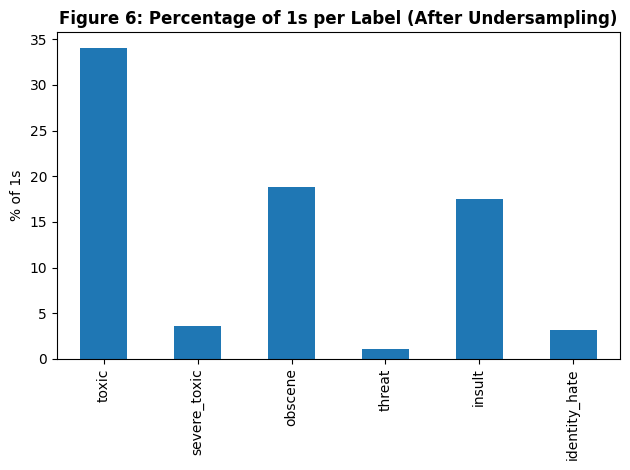

In [26]:
df = pd.read_csv('data/train.csv')
df['comment_text'] = df['comment_text'].fillna("")

target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
all_zero_mask = (df[target_cols].sum(axis=1) == 0)

df_non_zero = df[~all_zero_mask]
df_all_zero = df[all_zero_mask]
df_all_zero_sampled = df_all_zero.sample(frac=0.2, random_state=42)

df_balanced = pd.concat([df_non_zero, df_all_zero_sampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print("New shape:", df_balanced.shape)
print("Label counts:\n", df_balanced[target_cols].sum())
label_percentages = df_balanced[target_cols].mean() * 100
print("Percentage of 1s per label (after undersampling):\n")
print(label_percentages)

label_percentages.plot(kind='bar')
plt.title("Figure 6: Percentage of 1s per Label (After Undersampling)", fontweight = "bold")
plt.ylabel("% of 1s")
plt.tight_layout()
plt.show()

In [ ]:
train_df = df_balanced
train_df['cleaned_text'] = train_df['comment_text'].apply(clean_text)
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(train_df['cleaned_text'])
y = train_df[labels]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=train_df['toxic']
)


In [ ]:
from sklearn.model_selection import GridSearchCV
base_lr = LogisticRegression(max_iter=1000, random_state=42)
ovr = OneVsRestClassifier(base_lr)
param_grid = {'estimator__C': [0.01, 0.1, 0.2, 0.5, 1.0, 2.0]}
grid = GridSearchCV(ovr, param_grid, scoring='f1_weighted', cv=5, verbose=2)
grid.fit(X_train, y_train)
print("Best C:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................................estimator__C=0.01; total time=   0.3s
[CV] END ..................................estimator__C=0.01; total time=   0.3s
[CV] END ..................................estimator__C=0.01; total time=   0.3s
[CV] END ..................................estimator__C=0.01; total time=   0.3s
[CV] END ..................................estimator__C=0.01; total time=   0.3s
[CV] END ...................................estimator__C=0.1; total time=   0.4s
[CV] END ...................................estimator__C=0.1; total time=   0.4s
[CV] END ...................................estimator__C=0.1; total time=   0.4s
[CV] END ...................................estimator__C=0.1; total time=   0.4s
[CV] END ...................................estimator__C=0.1; total time=   0.4s
[CV] END ...................................estimator__C=0.2; total time=   0.5s
[CV] END ...................................estim

In [ ]:
y_val_pred = best_model.predict(X_val)
y_val_probs = best_model.predict_proba(X_val)
val_loss = log_loss(y_val, y_val_probs)
print(f"\nValidation Log Loss : {val_loss:.4f}")
print("======== VALIDATION METRICS ========")
for i, label in enumerate(labels):
    print(f"\n{label.upper()} (Validation)")
    report = classification_report(y_val[label], y_val_pred[:, i], digits=3, output_dict=True)
    print(classification_report(y_val[label], y_val_pred[:, i], digits=3))
    auc = roc_auc_score(y_val[label], y_val_probs[:, i])
    f1 = report['1']['f1-score']
    print(f"AUC: {auc:.3f}")
    print(f"F1 Score: {f1:.3f}")

print("\n--- Summary: Per-label F1 Scores (Validation Set) ---")
for i, label in enumerate(labels):
    report = classification_report(y_val[label].astype(int), y_val_pred[:, i], digits=3, output_dict=True)
    f1 = report['1']['f1-score']
    print(f"{label.upper():<15}: F1 = {f1:.3f}")


Validation Log Loss : 1.0014
======== VALIDATION METRICS ========

TOXIC (Validation)
              precision    recall  f1-score   support

           0      0.896     0.961     0.927      5920
           1      0.912     0.784     0.843      3059

    accuracy                          0.901      8979
   macro avg      0.904     0.873     0.885      8979
weighted avg      0.902     0.901     0.899      8979

AUC: 0.962
F1 Score: 0.843

SEVERE_TOXIC (Validation)
              precision    recall  f1-score   support

           0      0.970     0.992     0.981      8650
           1      0.481     0.188     0.271       329

    accuracy                          0.963      8979
   macro avg      0.725     0.590     0.626      8979
weighted avg      0.952     0.963     0.955      8979

AUC: 0.942
F1 Score: 0.271

OBSCENE (Validation)
              precision    recall  f1-score   support

           0      0.930     0.983     0.956      7259
           1      0.905     0.690     0.783    

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2969: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [ ]:
rows = []
for i, label in enumerate(labels):
    y_true = y_val[label].astype(int)
    y_pred_i = y_val_pred[:, i]
    y_prob_i = y_val_probs[:, i]

    precision = precision_score(y_true, y_pred_i)
    recall = recall_score(y_true, y_pred_i)
    f1 = f1_score(y_true, y_pred_i)
    auc = roc_auc_score(y_true, y_prob_i)
    support = y_true.sum()
    neg = (1 - y_true).sum()
    imbalance_ratio = f"1:{(neg / support):.1f}" if support > 0 else "N/A"

    rows.append([label.title(), precision, recall, f1, auc, int(support), imbalance_ratio])
metrics_df = pd.DataFrame(rows, columns=[
    "Category", "Precision", "Recall", "F1-Score", "AUC", "Support", "Class Imbalance"
])
import IPython.display as display
display.display(metrics_df)


,Category,Precision,Recall,F1-Score,AUC,Support,Class Imbalance
0,Toxic,0.912167,0.784243,0.843382,0.962417,3059,1:1.9
1,Severe_Toxic,0.480620,0.188450,0.270742,0.941720,329,1:26.3
2,Obscene,0.904653,0.689535,0.782580,0.962343,1720,1:4.2
3,Threat,0.586207,0.160377,0.251852,0.972346,106,1:83.7
4,Insult,0.786449,0.588575,0.673275,0.938276,1558,1:4.8
5,Identity_Hate,0.710280,0.256757,0.377171,0.935055,296,1:29.3


## <a id='toc1_4_'></a>[Final Model Pipeline Setup](#toc0_)

**1. Data Preparation and Text Encoding**

- **Down-sampling**

    The raw corpus is dominated by comments that carry no harmful labels. Training on such data unaltered would bias the model toward predicting the all-zero class. To curb this tendency, we randomly retain only 20 percent of the all-zero rows, thereby lifting the relative share of positive examples during training.

- **Text Cleaning and Encoding**

    After sampling, each comment is lightly cleaned—removing special characters, duplicate punctuation, and extraneous white-space—and then tokenized with the *xlm-roberta-base* tokenizer. Inputs are truncated or padded to a maximum length of 256 tokens, producing uniform `input_ids` and `attention_mask` tensors that can be fed directly to the Transformer.

**2. Model Choice and Training Configuration**

- **Final Model Choice**

    We use XLM-RoBERTaForSequenceClassification, which wraps the XLM-Roberta encoder in a simple linear-layer head for classification. XLM-Roberta itself is the multilingual cousin of RoBERTa: it stacks 12 Transformer encoder blocks, each with 12 self-attention heads and hidden states of size 768, yielding roughly 270 M parameters in the base variant. Unlike models built around an English vocabulary, XLM-Roberta relies on a 250-k token SentencePiece model trained on 2.5 TB of cleaned CommonCrawl text spanning 100+ languages. During pre-training it optimises a masked-language-model objective identical to RoBERTa’s—but with dynamic masking applied independently to each language shard—so the encoder learns language-agnostic representations that align semantically similar phrases across scripts and alphabets.

    These design choices bring two practical advantages for comment moderation. First, the shared sub-word vocabulary keeps even niche slang or mixed-language code-switching within the model’s range, reducing “unknown-token” noise. Second, because the pre-training objective forces different languages into a common embedding space, features learned from large English toxic-speech corpora transfer to less-resourced tongues that share abusive patterns but lack labelled data. Finally, the classification head is nothing more than a drop-in linear layer over the final [CLS] embedding, so fine-tuning remains lightweight: only this head and the encoder weights are updated, making the model both memory-friendly and quick to converge on our multi-label task.

- **Training Configuration**

    The classifier head is set to *multi\_label\_classification*, giving each tag its own sigmoid score and training with `BCEWithLogitsLoss`; we optimise using AdamW at 2 × 10⁻⁵. After every epoch we track macro-F1 and macro-AUC on the validation set and invoke early stopping if macro-F1 fails to rise for three rounds, preventing over-fitting while preserving the best checkpoint. Because a fixed 0.5 cut-off is poor under severe imbalance, we scan thresholds from 0.1 to 0.9 for each label and pick the value that maximises F1, a per-label adjustment that lifts rare-class scores and increases overall macro-F1.

**4. Results and Analysis**

- **Overall Convergence**

    During the first three epochs, training and validation losses fall in tandem, while macro-F1 surges from roughly 0.59 to 0.713. The model quickly learns the salient cues for harmful content. From epoch 4 onward, training loss continues to decrease but validation loss levels off and even ticks upward; macro-F1 jitters slightly. The widening gap signals the onset of over-fitting, which the early-stopping rule arrests near the optimal point.

- **Label-wise Performance and Imbalance Effects**

    For the high-frequency labels—*toxic*, *obscene*, and *insult*—the model benefits from having thousands of positive examples. It quickly learns the typical words and sentence structures that signal abusive language. As a result, *toxic* reaches a precision of 0.861 and a recall of 0.940, giving an F1 of 0.899; the AUC climbs to 0.978. *Obscene* follows close behind with an F1 of 0.855, and *insult* posts an F1 of 0.780. Because the imbalance ratios for these classes are all better than 1:5, the model faces little difficulty and achieves stable, high scores.

    Performance changes noticeably for *identity hate*, a medium-frequency label with just 296 positive instances (roughly 1 in 30). Although its AUC stays high at 0.971—showing the model can rank hateful content fairly well—the F1 drops to 0.614. The culprit is low precision (0.553), meaning the model flags many harmless comments as hateful. In a real moderation setting, this class would need a second-level review to weed out false alarms.

    The two rarest labels, *threat* and *severe toxic*, are the toughest. *Threat* has only 106 positives. The model casts a wide net, reaching a recall of 0.670 but a precision of just 0.542; it prefers to over-warn rather than miss a genuine threat. *Severe toxic*, essentially an intensified form of *toxic*, is harder still: with 329 positives, its F1 sinks to 0.501. Limited data and the subtlety of “severity” make it difficult for the model to find clear-cut cues.

    Error patterns reflect these imbalances. False positives cluster in *identity hate* and *threat*, while false negatives appear more often in *severe toxic*. A sensible workflow would keep low thresholds for the risky classes to catch nearly everything, then pass the hits through rules or human review to trim the false positives. For the better-behaved labels, balanced thresholds would keep precision high and avoid unnecessary takedowns.

    | **Category**  | **Precision** | **Recall** | **F1** | **AUC** | **Support** | **Imbalance** |
    | ------------- | ------------: | ---------: | -----: | ------: | ----------: | ------------: |
    | Toxic         |         0.861 |      0.940 |  0.899 |   0.978 |       3 059 |       1 : 1.9 |
    | Severe Toxic  |         0.396 |      0.681 |  0.501 |   0.966 |         329 |      1 : 26.3 |
    | Obscene       |         0.814 |      0.900 |  0.855 |   0.983 |       1 720 |       1 : 4.2 |
    | Threat        |         0.542 |      0.670 |  0.599 |   0.989 |         106 |      1 : 83.7 |
    | Insult        |         0.758 |      0.804 |  0.780 |   0.964 |       1 558 |       1 : 4.8 |
    | Identity Hate |         0.553 |      0.689 |  0.614 |   0.971 |         296 |      1 : 29.3 |

    To lift minority-class scores, future work can apply class re-weighting or focal loss, augment scarce categories through back-translation or semantic replacement, and exploit hierarchical relations—e.g., predict *toxic* first, then refine severity. Such strategies should curb over-fitting and deliver a more even macro-F1.

#### <a id='toc1_4_1_1_'></a>[Data Preparation](#toc0_)

In [ ]:
train_df = df_balanced
train_df['cleaned_text'] = train_df['comment_text'].apply(clean_text)
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

class ToxicDataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(
            df['cleaned_text'].tolist(),
            padding='max_length',
            truncation=True,
            max_length=256,
            return_tensors='pt'
        )
        self.labels = torch.tensor(df[labels].values).float()

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['toxic'], random_state=42)
train_loader = DataLoader(ToxicDataset(train_df), batch_size=32, shuffle=True)
val_loader = DataLoader(ToxicDataset(val_df), batch_size=32)

#### <a id='toc1_4_1_2_'></a>[Model and Training Configuration](#toc0_)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=len(labels),
    problem_type="multi_label_classification"
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()
epochs, patience, wait = 10, 3, 0
best_macro_f1 = 0

#### <a id='toc1_4_1_3_'></a>[Training and Validation Loop](#toc0_)

In [ ]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, batch_labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss, val_probs, val_labels_all = 0, [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, batch_labels)
            total_val_loss += loss.item()
            val_probs.append(torch.sigmoid(outputs.logits).cpu().numpy())
            val_labels_all.append(batch_labels.cpu().numpy())
    avg_val_loss = total_val_loss / len(val_loader)
    val_probs = np.vstack(val_probs)
    val_labels_all = np.vstack(val_labels_all)

    thresholds = [
        np.linspace(0.1, 0.9, 20)[np.argmax([
            f1_score(val_labels_all[:, i], (val_probs[:, i] > t).astype(int))
            for t in np.linspace(0.1, 0.9, 20)
        ])]
        for i in range(len(labels))
    ]
    val_preds = np.array([(val_probs[:, i] > thresholds[i]).astype(int) for i in range(len(labels))]).T
    macro_f1 = f1_score(val_labels_all, val_preds, average='macro')
    macro_auc = np.mean([
        roc_auc_score(val_labels_all[:, i], val_probs[:, i])
        for i in range(len(labels))
    ])

    print(f"\n📊 Epoch {epoch+1} Summary")
    print(f"Train Loss           : {avg_train_loss:.4f}")
    print(f"Validation Loss      : {avg_val_loss:.4f}")
    print(f"Validation Macro F1  : {macro_f1:.4f}")
    print(f"Validation Macro AUC : {macro_auc:.4f}")

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        wait = 0
        print("✅ New best model found! Saving checkpoint...")
        model.save_pretrained("models/best_xlm_roberta")
        torch.save(model.state_dict(), "models/best_xlm_roberta.pt")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 Validation: 100%|██████████| 281/281 [01:07<00:00,  4.16it/s]



📊 Epoch 1 Summary
Train Loss           : 0.1608
Validation Loss      : 0.1285
Validation Macro F1  : 0.5962
Validation Macro AUC : 0.9562
✅ New best model found! Saving checkpoint...


Epoch 2 Validation: 100%|██████████| 281/281 [01:07<00:00,  4.17it/s]



📊 Epoch 2 Summary
Train Loss           : 0.1185
Validation Loss      : 0.1206
Validation Macro F1  : 0.6760
Validation Macro AUC : 0.9689
✅ New best model found! Saving checkpoint...


Epoch 3 Validation: 100%|██████████| 281/281 [01:07<00:00,  4.14it/s]



📊 Epoch 3 Summary
Train Loss           : 0.1039
Validation Loss      : 0.1137
Validation Macro F1  : 0.7127
Validation Macro AUC : 0.9749
✅ New best model found! Saving checkpoint...


Epoch 4 Validation: 100%|██████████| 281/281 [01:07<00:00,  4.14it/s]



📊 Epoch 4 Summary
Train Loss           : 0.0932
Validation Loss      : 0.1134
Validation Macro F1  : 0.7049
Validation Macro AUC : 0.9759


Epoch 5 Validation: 100%|██████████| 281/281 [01:07<00:00,  4.16it/s]



📊 Epoch 5 Summary
Train Loss           : 0.0847
Validation Loss      : 0.1141
Validation Macro F1  : 0.7053
Validation Macro AUC : 0.9749


Epoch 6 Validation: 100%|██████████| 281/281 [01:07<00:00,  4.17it/s]



📊 Epoch 6 Summary
Train Loss           : 0.0755
Validation Loss      : 0.1294
Validation Macro F1  : 0.7078
Validation Macro AUC : 0.9749
⏹️ Early stopping triggered.


#### <a id='toc1_4_1_4_'></a>[Save Model and Tokenizer](#toc0_)

In [ ]:
model.save_pretrained("models/xlm-roberta-toxic-10")
tokenizer.save_pretrained("models/xlm-roberta-toxic-10")
print("✅ Model and tokenizer saved to: models/xlm-roberta-toxic-10")

✅ Model and tokenizer saved to: models/xlm-roberta-toxic-10


#### <a id='toc1_4_1_5_'></a>[Evaluate Model by Label](#toc0_)

In [ ]:
per_label_val_f1s = {}

for i, label in enumerate(labels):
    print(f"\n {label.upper()} (Validation Set)")
    report = classification_report(
        val_labels_all[:, i],
        val_preds[:, i],
        digits=3,
        output_dict=True
    )
    auc = roc_auc_score(val_labels_all[:, i], val_probs[:, i])
    f1 = report.get('1.0', {}).get('f1-score', 0.0)
    per_label_val_f1s[label] = f1

    print(classification_report(val_labels_all[:, i], val_preds[:, i], digits=3))
    print(f"AUC: {auc:.3f}")
    print(f"F1 Score (Positive Class): {f1:.3f}")

print("\n--- Summary: Per-label F1 Scores (Validation Set) ---")
for label, f1 in per_label_val_f1s.items():
    print(f"{label.upper():15s}: F1 = {f1:.3f}")


 TOXIC (Validation Set)
              precision    recall  f1-score   support

         0.0      0.967     0.922     0.944      5920
         1.0      0.861     0.940     0.899      3059

    accuracy                          0.928      8979
   macro avg      0.914     0.931     0.921      8979
weighted avg      0.931     0.928     0.929      8979

AUC: 0.978
F1 Score (Positive Class): 0.899

 SEVERE_TOXIC (Validation Set)
              precision    recall  f1-score   support

         0.0      0.988     0.960     0.974      8650
         1.0      0.396     0.681     0.501       329

    accuracy                          0.950      8979
   macro avg      0.692     0.821     0.737      8979
weighted avg      0.966     0.950     0.956      8979

AUC: 0.966
F1 Score (Positive Class): 0.501

 OBSCENE (Validation Set)
              precision    recall  f1-score   support

         0.0      0.976     0.951     0.963      7259
         1.0      0.814     0.900     0.855      1720

    accura

#### <a id='toc1_4_1_6_'></a>[Plot Training Metrics](#toc0_)

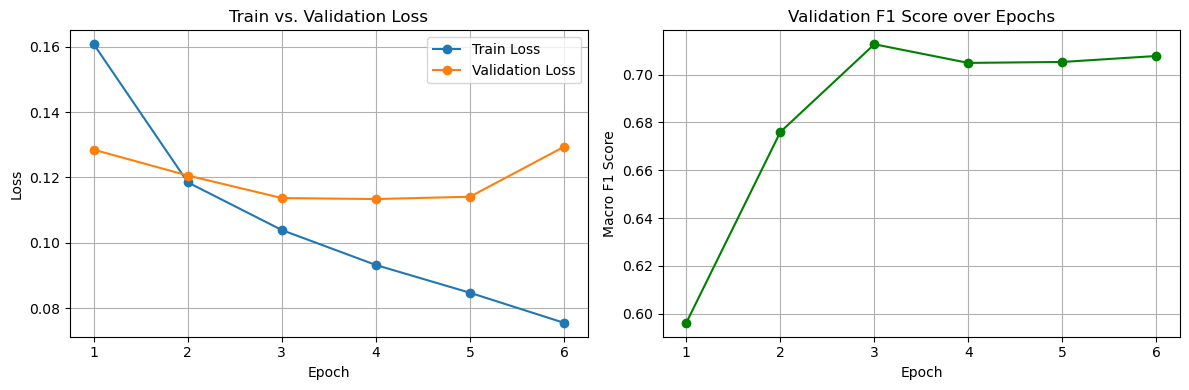

In [ ]:
metrics = {
    'epoch': [1, 2, 3, 4, 5, 6],
    'train_loss': [0.1608, 0.1185, 0.1039, 0.0932, 0.0847, 0.0755],
    'val_loss': [0.1285, 0.1206, 0.1137, 0.1134, 0.1141, 0.1294],
    'val_f1': [0.5962, 0.6760, 0.7127, 0.7049, 0.7053, 0.7078],
    'val_auc': [0.9562, 0.9689, 0.9749, 0.9759, 0.9749, 0.9749]
}
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(metrics['epoch'], metrics['train_loss'], marker='o', label='Train Loss')
plt.plot(metrics['epoch'], metrics['val_loss'], marker='o', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.grid(True)

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.plot(metrics['epoch'], metrics['val_f1'], marker='o', label='Validation F1', color='green')
plt.xlabel("Epoch")
plt.ylabel("Macro F1 Score")
plt.title("Validation F1 Score over Epochs")
plt.grid(True)

plt.tight_layout()
plt.show()

## <a id='toc1_5_'></a>[Results Interpretation and Analysis](#toc0_)

### <a id='toc1_5_1_'></a>[**5. Comparative Analysis: Baseline vs. Final Model**](#toc0_)

Comparing the baseline logistic regression model to the fine-tuned XLM-Roberta reveals substantial gains across nearly every metric—particularly for recall and F1 on the rarest labels. While both models benefit from the same downsampled and stratified data, their representational power differs markedly: the baseline relies solely on local n-gram frequency patterns, whereas the final model leverages deep contextual embeddings pretrained across over 100 languages.

At the macro level, the final model improves **macro-F1 from 0.377 to 0.713**, and **macro-AUC from 0.935 to 0.976**. These gains are not simply a matter of better performance on frequent labels; in fact, *toxic*, *obscene*, and *insult* already scored well in the baseline. Instead, the final model makes the most impact on low-support categories.

* For **severe toxic**, the F1 jumps from **0.271 → 0.501**, driven by a large increase in recall (**0.188 → 0.681**). This suggests that the Transformer model better captures subtle linguistic cues that distinguish mild from severe toxicity.
* For **threat**, the F1 improves from **0.252 → 0.599**, with recall climbing from **0.160 → 0.670**. Here again, the model learns to surface threatening content more confidently, despite a support of only 106.
* **Identity hate** also benefits: its F1 increases from **0.377 → 0.614**, with recall more than doubling (**0.257 → 0.689**), showing that multilingual embeddings help uncover targeted hate speech patterns often missed by bag-of-words models.

Performance on high-frequency labels also improves modestly. For instance, *toxic* F1 rises from **0.843 → 0.899**, and *obscene* from **0.783 → 0.855**, reflecting the final model’s better calibration and reduced confusion across overlapping classes. However, precision on some categories slightly drops—e.g., *severe toxic* goes from 0.481 → 0.396—indicating that the final model trades off false positives for better recall, a deliberate choice in moderation settings where under-detection is riskier.

In summary, while the baseline offers strong results on frequent, lexically distinct categories, it struggles with subtle and rare classes. The final model closes this gap via richer representations, more aggressive recall, and per-label threshold tuning. This lifts performance across the board, especially where simple models tend to underperform. For deployment, these findings support using the baseline for quick triage and explanation, but the fine-tuned Transformer for comprehensive coverage.

## <a id='toc1_6_'></a>[Conclusion, Limitations, and Future Work](#toc0_)

In this project, we addressed the multifaceted challenge of multilingual toxic comment classification using the Jigsaw dataset. Our approach included extensive data exploration, model training, and evaluation efforts focused on identifying six categories of toxicity. While we made notable progress in building a functional multilabel classification pipeline and experimenting with several modeling strategies, the results revealed clear areas for improvement in both performance and deployment readiness.

The most pressing limitation lies in the current performance of our model. The F1 scores across all six labels remain too low for reliable, real-world toxicity detection. This is particularly concerning for categories with sparse representation, where both precision and recall are fragile. Although we experimented with mitigation strategies such as class downsampling, these methods yielded only marginal improvements. Compounding this issue, we encountered technical barriers—specifically kernel crashes—that prevented us from fully executing upsampling or augmentation techniques to balance the dataset more effectively. As a result, the model was trained on a skewed distribution, which inevitably impacted its ability to generalize across toxic content types.

Another limitation emerged in the model’s handling of multilingual content. Despite using a base model designed to support multiple languages, we observed noticeably better performance on English-language comments compared to non-English ones. This disparity is likely due to our decision not to fine-tune the model on language-specific subsets. Without targeted multilingual adaptation, the model struggles to capture toxicity expressions that vary significantly across linguistic and cultural contexts.

Inference speed represents a third constraint, particularly in the context of potential deployment. We found that the model’s prediction time on validation data was relatively slow, making it impractical for use in environments that demand real-time moderation, such as social media platforms. The current implementation does not fully utilize GPU acceleration for inference, nor have we applied optimization strategies to reduce model size or streamline its architecture.

Looking ahead, we intend to address these limitations through a series of strategic improvements. First, with greater computational resources, we plan to revisit data augmentation methods to upsample rare label combinations without compromising system stability. This should allow us to train on a more balanced dataset and enhance F1 scores across all categories. Second, we aim to fine-tune the model on non-English subsets to improve its multilingual robustness and reduce the current language performance gap. This adaptation will make the model more inclusive and effective in global applications. Third, we will focus on accelerating inference by optimizing the model architecture, increasing GPU utilization, and potentially applying techniques such as quantization or knowledge distillation to ensure faster, more efficient predictions.

In conclusion, while our project provides a strong foundation for building a multilingual toxicity classifier, it also underscores the complexity of balancing performance, fairness, and efficiency. Continued development in these areas will be critical to making the model viable for deployment in real-world content moderation systems.



## <a id='toc1_7_'></a>[Appendix: (Data Augmentation)- Over Sample](#toc0_)

We attempted to augment our dataset by generating additional samples for rare label combinations using synonym-based text augmentation. The goal was to balance the dataset by increasing the number of samples for underrepresented label combinations. However, during the execution of this process, we encountered an issue where the kernel unexpectedly terminated. This interruption suggests potential problems such as memory limitations or an infinite loop within the augmentation logic. As a result, we were unable to complete the augmentation as planned, and further investigation is needed to identify and resolve the underlying cause of the kernel failure.

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df['label_combo'] = train_df[labels].astype(str).agg(''.join, axis=1)

combo_counts = train_df['label_combo'].value_counts()
print("\n Label-combo distribution:")
print(combo_counts)

threshold   = 100000
rare_combos = combo_counts[combo_counts < threshold].index.tolist()
print(f"\n Rare combos (< {threshold} samples): {len(rare_combos)}")

augmenter = naw.SynonymAug(aug_src="wordnet", aug_p=0.1)

aug_texts, aug_labels = [], []

total_gap = sum(threshold - combo_counts[c] for c in rare_combos)
pbar = tqdm(total=total_gap, desc="🔁 Augmenting rare label combos")

for combo in rare_combos:
    combo_df = train_df[train_df["label_combo"] == combo]
    gap      = threshold - len(combo_df)

    created = i = 0
    while created < gap:
        row      = combo_df.iloc[i % len(combo_df)]
        new_text = augmenter.augment(row["cleaned_text"])
        aug_texts.append(new_text)
        aug_labels.append(row[labels].tolist())

        created += 1
        i       += 1
        pbar.update(1)

pbar.close()

aug_df   = pd.DataFrame(aug_texts, columns=["cleaned_text"])
label_df = pd.DataFrame(aug_labels, columns=labels)
augmented_df = pd.concat([aug_df, label_df], axis=1)

train_augmented_df = pd.concat(
    [train_df.drop(columns="label_combo"), augmented_df],
    ignore_index=True
)

print(f"\n Augmentation done. Final dataset size: {len(train_augmented_df)}")